# CNN model to detect anc localise sources

### Collect source and background datasets

In [43]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
src_info = f'/data01/homes/dipiano/E4/z60_NLST/crab/sim/merged_data.dat'
bkg_info = f'/data01/homes/dipiano/E4/z60_NLST/background/sim/merged_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/z60_NLST/ds_50s_5sgm_1000sz.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"SRC dataset size: {len(ds['SRC'])}")
print(f"BKG dataset size: {len(ds['BKG'])}")

Maps: dict_keys(['SRC', 'BKG'])
SRC dataset size: 1000
BKG dataset size: 1000


### Split train and test datasets

In [44]:
from astroai.tools.utils import split_dataset

train_data, train_labels, test_data, test_labels = split_dataset(ds, split=80, reshape=True, binning=250)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

assert all(train_labels[:int(len(train_labels)/2)]) == 1
assert all(train_labels[int(len(train_labels)/2):]) == 0
assert all(test_labels[:int(len(test_labels)/2)]) == 1
assert all(test_labels[int(len(test_labels)/2):]) == 0

Train dataset: 1600, (1600, 250, 250, 1)
Train labels: 1600, (1600, 1)

Test dataset: 400, (400, 250, 250, 1)
Test labels: 400, (400, 1)


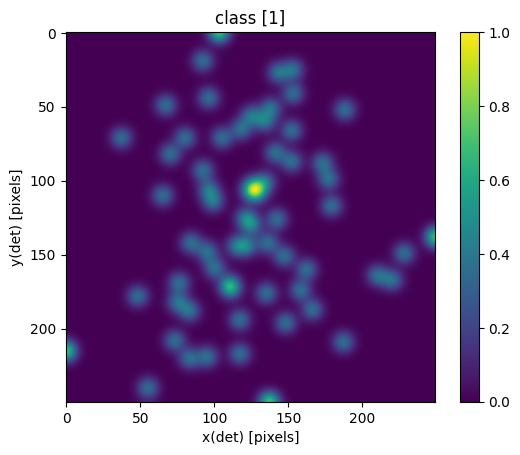

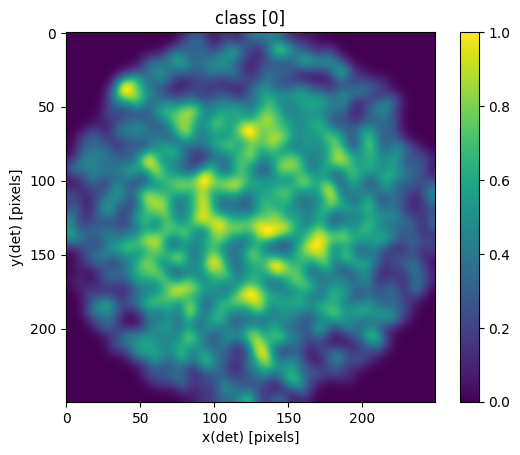

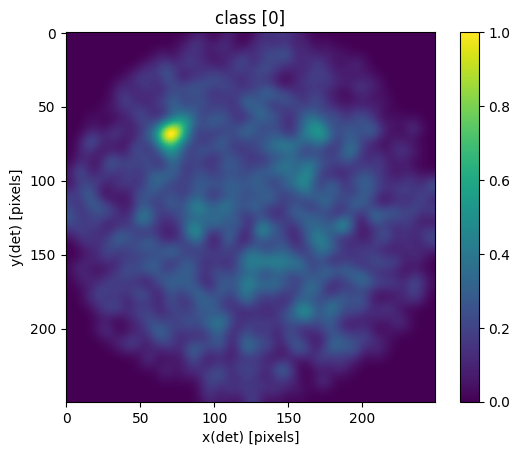

In [45]:
from astroai.tools.utils import plot_heatmap

idx = 802
plot_heatmap(train_data[0], title=f'class {train_labels[0]}', show=True, save=False, save_name=None)
plot_heatmap(train_data[-1], title=f'class {train_labels[-1]}', show=True, save=False, save_name=None)
plot_heatmap(train_data[idx], title=f'class {train_labels[idx]}', show=True, save=False, save_name=None)

### Create the model

In [40]:
import tensorflow as tf
from astroai.models.cnn import create_cnn_detector
TF_CPP_MIN_LOG_LEVEL="1"

# seed
tf.random.set_seed(42)
np.random.seed(42)

# create TF dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# create model
model = create_cnn_detector()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 246, 246, 2)       52        
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 123, 123, 2)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 2)       102       
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 59, 59, 2)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 2)         102       
                                                                 
 drop_1 (Dropout)            (None, 55, 55, 2)         0         
                                                                 
 flat_1 (Flatten)            (None, 6050)             

### Compile the model

In [42]:
from astroai.models.cnn import compile_and_fit_detector

history = compile_and_fit_classifier(model=model, train_ds=train_dataset, test_ds=test_dataset, 
                                     batch_sz=32, epochs=25, shuffle=True, learning=0.001)

Epoch 1/25


ValueError: in user code:

    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/data01/homes/dipiano/venvs/astroai/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv2d_1' (type Conv2D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential_3/conv2d_1/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_3/Cast, sequential_3/conv2d_1/Conv2D/ReadVariableOp)' with input shapes: [250,250,1,1], [5,5,1,2].
    
    Call arguments received by layer 'conv2d_1' (type Conv2D):
      • inputs=tf.Tensor(shape=(250, 250, 1, 1), dtype=float32)


### Plot loss and accuracy

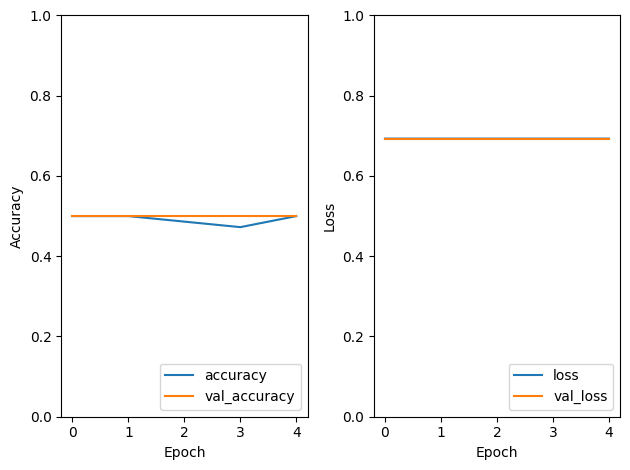

13/13 - 0s - loss: 0.6931 - accuracy: 0.5000 - 333ms/epoch - 26ms/step


In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0,1])
ax[0].legend(loc='lower right')

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([0,1])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)